In [1]:
import pandas as pd
import numpy as np
from py_geohash_any import geohash as gh
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
#!/usr/bin/env python
from __future__ import print_function


import random
import numpy as np
from collections import deque

import json
from collections import defaultdict
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD , Adam
import tensorflow as tf

import sys
sys.path.insert(0, '../src/data')
import auxiliary_functions, make_dataset
from auxiliary_functions import convert_miles_to_minutes_nyc, list_of_output_predictions_to_direction

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


### Data Dictionary : Yellow Taxi Cab
- VendorID A code indicating the TPEP provider that provided the record.
1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.
- tpep_pickup_datetime The date and time when the meter was engaged.
- tpep_dropoff_datetime The date and time when the meter was disengaged.
- Passenger_count The number of passengers in the vehicle.
 This is a driver-entered value.
- Trip_distance The elapsed trip distance in miles reported by the taximeter.
- Pickup_longitude Longitude where the meter was engaged.
- Pickup_latitude Latitude where the meter was engaged.
- RateCodeID The final rate code in effect at the end of the trip.
 1= Standard rate 
 2=JFK
 3=Newark
 4=Nassau or Westchester
 5=Negotiated fare
 6=Group ride
- Store_and_fwd_flag This flag indicates whether the trip record was held in vehicle
 memory before sending to the vendor, aka “store and forward,”
 because the vehicle did not have a connection to the server.
- Y= store and forward trip
- N= not a store and forward trip
- Dropoff_longitude Longitude where the meter was disengaged.
- Dropoff_ latitude Latitude where the meter was disengaged.
- Payment_type A numeric code signifying how the passenger paid for the trip.
 1= Credit card
 2= Cash
 3= No charge
 4= Dispute
 5= Unknown
 6= Voided trip
- Fare_amount The time-and-distance fare calculated by the meter.
- Extra Miscellaneous extras and surcharges. Currently, this only includes
 t he 0.50 and 1 rush hour and overnight charges.
 M TA_tax 0.50 MTA tax that is automatically triggered based on the metered
 rate in use.
- Improvement_surcharge 0.30 improvement surcharge assessed trips at the flag drop. The
- improvement surcharge began being levied in 2015.
- Tip_amount Tip amount – This field is automatically populated for credit card
 tips. Cash tips are not included.
- Tolls_amount Total amount of all tolls paid in trip.
- Total_amount The total amount charged to passengers. Does not include cash tips.

### Geohash dictionary the distance between geohashes based on matching characters, in meters.
_PRECISION = {
    0: 20000000,
    1: 5003530,
    2: 625441,
    3: 123264,
    4: 19545,
    5: 3803,
    6: 610,
    7: 118,
    8: 19,
    9: 3.71,
    10: 0.6,
}

### Average speed of taxis in Manhattan
- In 2014, it dropped to 8.51 MPH. http://www.wnyc.org/story/traffic-speeds-slow-nyc-wants-curb-car-service-growth/
- 8.51 MPH is 3.80431 meters / second

### Geohash units are meters
- http://stackoverflow.com/questions/13448595/geohash-string-length-and-accuracy

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#yellow_taxi_geohash_min_day
taxi_yellowcab_df, final_data_structure= make_dataset.main()

Opening up data
Group data
Creating the final data structure


In [4]:
# sample of the final data structure
final_data_structure[1110]['Zct8R']

[(14.765, 20, 0.7382499999630875),
 (12.815200000000004, 20, 0.6407599999679622),
 (12.74269230769231, 20, 0.6371346153527588),
 (11.510000000000003, 10, 1.1509999998849003),
 (13.840303030303033, 20, 0.6920151514805509),
 (13.59464285714286, 10, 1.3594642855783396),
 (12.480285714285715, 10, 1.2480285713037687),
 (13.586486486486491, 10, 1.3586486485127842),
 (11.100800000000003, 10, 1.1100799998889923),
 (9.999090909090913, 10, 0.9999090908091004),
 (12.540000000000001, 10, 1.2539999998746),
 (16.846790123456774, 20, 0.8423395061307217),
 (14.20904761904762, 20, 0.7104523809168584),
 (13.19685714285715, 10, 1.3196857141537464),
 (13.012058823529417, 10, 1.3012058822228212),
 (10.919736842105266, 10, 1.0919736841013292),
 (12.727187500000001, 20, 0.6363593749681821),
 (10.53694444444445, 10, 1.0536944443390754),
 (13.375609756097564, 10, 1.3375609754760003),
 (15.676341463414628, 10, 1.5676341461846994),
 (15.99925, 20, 0.7999624999600019),
 (12.792558139534883, 10, 1.2792558138255627

In [5]:
# the data
taxi_yellowcab_df.head(10)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,geohash_pickup,geohas_dropoff,jan_day,jan_minute,geohash_dropoff,trip_time_minutes
0,0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,...,0.0,0.0,0.3,8.8,Zct8X,dr5rsx,1,0,dr5rsx,10
1,1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,...,0.0,0.0,0.3,19.3,Zct8c,dr5rtk,1,0,dr5rtk,30
2,2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,...,0.0,0.0,0.3,34.3,Zct5T,dr72j1,1,0,dr72j1,60
3,3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,...,0.0,0.0,0.3,17.3,Zct8Q,dr5rkc,1,0,dr5rkc,30
4,4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,...,0.0,0.0,0.3,8.8,Zc4oK,dr5rue,1,0,dr5rue,10
5,5,2,2016-01-01 00:00:00,2016-01-01 00:18:30,2,5.52,-73.980118,40.743050,1,N,...,0.0,0.0,0.3,20.3,Zct9J,dr5ryh,1,18,dr5ryh,30
6,6,2,2016-01-01 00:00:00,2016-01-01 00:26:45,2,7.45,-73.994057,40.719990,1,N,...,0.0,0.0,0.3,27.3,Zct8Q,dr72hc,1,26,dr72hc,40
7,7,1,2016-01-01 00:00:01,2016-01-01 00:11:55,1,1.20,-73.979424,40.744614,1,N,...,0.0,0.0,0.3,10.3,Zct9J,dr5ru7,1,11,dr5ru7,10
8,8,1,2016-01-01 00:00:02,2016-01-01 00:11:14,1,6.00,-73.947151,40.791046,1,N,...,0.0,0.0,0.3,19.3,Zc4oj,dr72mz,1,11,dr72mz,40
9,9,2,2016-01-01 00:00:02,2016-01-01 00:11:08,1,3.21,-73.998344,40.723896,1,N,...,0.0,0.0,0.3,12.8,Zct8R,dr5rkp,1,11,dr5rkp,20


# Finding neighbors from a dropoff geohash
- use gh.neighbors
- Convert these neighbors to an output index from the neural network

In [6]:
gh.neighbors(taxi_yellowcab_df.geohash_dropoff[0])

{'e': 'dr5rsz',
 'n': 'dr5rs0',
 'ne': 'dr5rs2',
 'nw': 'dr5rse',
 's': 'dr5rsw',
 'se': 'dr5rsy',
 'sw': 'dr5rsa',
 'w': 'dr5rsb'}

In [7]:
# Dictionary to convert these distances into the output from the Neural Network
# Outputs are nine numbers which correspond to a direction to go in
# 0) NW 1) N                     2) NE
# 3) W  4) Stay in same geohash  5)E
# 6)SW  7) S                    8) SE
list_of_output_predictions_to_direction={0:'nw',1:'n',2:'ne',3:'w',4:'stay',5:'e',6:'sw',7:'s',8:'se'}

# How many different paths are there for a cab driver to take
- 1) Assuming you can go to every geohash (not possible)
- 2) In a day

In [125]:
# How many total paths are there? Each hash has eight neighbors 9**(3086+1)-1 (nine because can go back to same node)?
len(str(9**(3086+1)-1))

2946

In [126]:
9**(3086+1)-1

5579902870072604520781768502574482838546250466479394679120423233865123088592389991017461272488545405947765927162973387932045022005649438467688986550554080894185396774521488734899097433560201783213247514879997422269344026429651880573126493783573017994538196988029386545666816019319724615929720075669428086745884640756582690931484927980211133964573153734354721166826860261443322744314068689260103258399221523423491086073730155749220812428859992609815473080036165549503067436533672536096771042279671074422297963752772874873262444107295806867918725513984107605763341504022359073978439306375832553510771427946743018584229245035857393349814173061883996462261039520359742300610335672925845092698960913043438763887415592711932793128251312269833014286519114532326985228736857198782870587228937486706651907834860273160740002634916801037884326483826754329680352728721901803066745050394781620769573763795067015177936781922172428117223520055663389664154063119619522401577699134093725128957954328067620982202878843

In [127]:
# how man geohashes can you visit in a day?
9**(288+1)-1

597152463056842341908762024185418685054207056332314478347827352460764734375345345870603172419123868750295983288569263632574908815378078302580224585346653298324734195047557342194681056539164109295762036073231747763356454020325313392530348032063147781100083853910415445388545288

In [128]:
len(str(9**(288+1)-1))

276

# Heat Map of the most profitable geohashes

In [12]:
pickup_sum_fare = taxi_yellowcab_df.groupby('geohash_pickup').sum()['total_amount'].reset_index()


In [13]:
pickup_sum_fare = pickup_sum_fare.sort_values(by='total_amount',ascending=False)

In [14]:
pickup_sum_fare['total_amount']= pickup_sum_fare.total_amount.apply(lambda x: round(x))

In [15]:
# can only plot 2k values on google maps

In [16]:
#pickup_sum_fare.loc[:2000,:].to_csv("data/geohash_sum_fare_all_jan.csv",sep="\t", index=False)

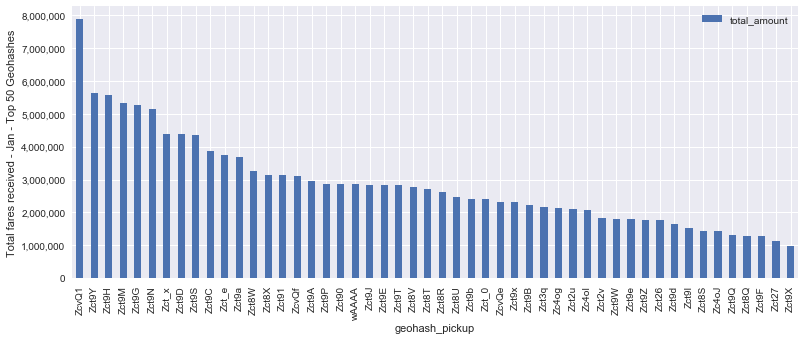

In [17]:
#plt.figure(figsize=(10,5))
ax = pickup_sum_fare[:50].plot(x='geohash_pickup',y='total_amount',kind='bar',figsize=(13,5))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.ylabel('Total fares received - Jan - Top 50 Geohashes')

## Break up the day into ten minute intervals( the time to traverse a geohash of ~3803 meters).
### Note: This code is already run in the make_data.main() call in the first cell
- Aggregate all of the days together so that you have one 24 hour block
- For this 24 hour block, group by five minute periods
- For each period, take the geohash as the key and a list of tuples of ( average fares over the month, trip times in minutes)
- This gives an end result of the average fare and corresponding trip time and ration of fare/trip time for each geohash for a given ten minutes over each day in January

In [ ]:

    
taxi_yellowcab_df['trip_time_minutes'] = taxi_yellowcab_df.trip_distance.apply(lambda x: convert_miles_to_minutes_nyc(x))

In [ ]:
# distribution of trip times
trip_minutes_grouped = taxi_yellowcab_df.groupby('trip_time_minutes').count()

In [ ]:
plt.figure(figsize=(20,10))
grid = sns.barplot(x = trip_minutes_grouped['VendorID'].reset_index()['trip_time_minutes'][:50],
            y= trip_minutes_grouped['VendorID'].reset_index()['VendorID'][:50])
grid.set( yscale="log")
plt.ylabel('Number of trips (base 10)')
plt.title('Disitribution of Trip Times')

## Index the geohashes to a number
#### List of possible times

In [11]:
## get a list of unique geohashes
list_of_unique_geohashes = taxi_yellowcab_df.geohash_pickup.unique()
len(list_of_unique_geohashes)

3086

In [12]:
list_of_geohash_index  = defaultdict(int)
for idx,hash_n in enumerate(list_of_unique_geohashes):
    list_of_geohash_index [hash_n] = idx

In [13]:
list_of_inverse_heohash_index = defaultdict(str)
for idx,hash_n in enumerate(list_of_unique_geohashes):
    list_of_inverse_heohash_index[idx] = hash_n

In [14]:
list_of_inverse_heohash_index

defaultdict(str,
            {0: 'Zct8X',
             1: 'Zct8c',
             2: 'Zct5T',
             3: 'Zct8Q',
             4: 'Zc4oK',
             5: 'Zct9J',
             6: 'Zc4oj',
             7: 'Zct8R',
             8: 'Zct3r',
             9: 'Zct9a',
             10: 'Zct8T',
             11: 'Zct3q',
             12: 'Zct8S',
             13: 'Zct9T',
             14: 'Zc4oM',
             15: 'Zct9W',
             16: 'Zct5w',
             17: 'Zct8W',
             18: 'Zct9B',
             19: 'Zct8V',
             20: 'Zct8P',
             21: 'Zct91',
             22: 'Zct9H',
             23: 'Zct9m',
             24: 'Zct8U',
             25: 'Zct9c',
             26: 'Zct8Y',
             27: 'Zct9e',
             28: 'wAAAA',
             29: 'Zc4oO',
             30: 'Zct6T',
             31: 'Zct9M',
             32: 'Zc4og',
             33: 'Zct5f',
             34: 'Zct9R',
             35: 'Zct8d',
             36: 'Zct9D',
             37: 'Zct9N',
     

In [15]:
hours = [str(_) for _ in range(24)]
minutes = [str(_) for _ in range(0,60,10)]
minutes.append('00')
list_of_time_index =[]
for h in hours:
    for m in minutes:

        list_of_time_index.append(int(str(h)+str(m)))
list_of_time_index = list(set(list_of_time_index))

In [16]:
list_of_time_index

[0,
 2050,
 1540,
 1030,
 520,
 10,
 1550,
 1040,
 530,
 20,
 1050,
 540,
 30,
 550,
 40,
 50,
 2100,
 60,
 2110,
 1600,
 70,
 2120,
 1610,
 1100,
 80,
 2130,
 1620,
 1110,
 600,
 90,
 2140,
 1630,
 1120,
 610,
 100,
 2150,
 1640,
 1130,
 620,
 110,
 1650,
 1140,
 630,
 120,
 1150,
 640,
 130,
 650,
 140,
 150,
 2200,
 160,
 2210,
 1700,
 170,
 2220,
 1710,
 1200,
 180,
 2230,
 1720,
 1210,
 700,
 190,
 2240,
 1730,
 1220,
 710,
 200,
 2250,
 1740,
 1230,
 720,
 210,
 1750,
 1240,
 730,
 220,
 1250,
 740,
 230,
 750,
 240,
 250,
 2300,
 2310,
 1800,
 2320,
 1810,
 1300,
 2330,
 1820,
 1310,
 800,
 2340,
 1830,
 1320,
 810,
 300,
 2350,
 1840,
 1330,
 820,
 310,
 1850,
 1340,
 830,
 320,
 1350,
 840,
 330,
 850,
 340,
 350,
 1900,
 1910,
 1400,
 1920,
 1410,
 900,
 1930,
 1420,
 910,
 400,
 1940,
 1430,
 920,
 410,
 1950,
 1440,
 930,
 420,
 1450,
 940,
 430,
 950,
 440,
 450,
 2000,
 2010,
 1500,
 2020,
 1510,
 1000,
 2030,
 1520,
 1010,
 500,
 2040,
 1530,
 1020,
 510]

In [30]:
taxi_yellowcab_df.columns

Index(['Unnamed: 0', 'VendorID', 'tpep_pickup_datetime',
       'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'geohash_pickup', 'geohas_dropoff', 'jan_day', 'jan_minute',
       'geohash_dropoff', 'trip_time_minutes'],
      dtype='object')

# Use an Actor Critic Model
- https://yanpanlau.github.io/2016/10/11/Torcs-Keras.html

In [75]:
def create_actor_network(self, state_size,action_dim):
        print("Now we build the model")
        S = Input(shape=[state_size])  
        h0 = Dense(HIDDEN1_UNITS, activation='relu')(S)
        h1 = Dense(HIDDEN2_UNITS, activation='relu')(h0)
        Steering = Dense(1,activation='tanh',init=lambda shape, name: normal(shape, scale=1e-4, name=name))(h1)   
        Acceleration = Dense(1,activation='sigmoid',init=lambda shape, name: normal(shape, scale=1e-4, name=name))(h1)   
        Brake = Dense(1,activation='sigmoid',init=lambda shape, name: normal(shape, scale=1e-4, name=name))(h1)   
        V = merge([Steering,Acceleration,Brake],mode='concat')          
        model = Model(input=S,output=V)
        print("We finished building the model")
        return model, model.trainable_weights, S

In [41]:
## Actor
HIDDEN1_UNITS=10
HIDDEN2_UNITS=20
state_size=5
print("Now we build the model")
S = Input(shape=[state_size])
h0 = Dense(HIDDEN1_UNITS, activation='relu')(S)
h1 = Dense(HIDDEN2_UNITS, activation='relu')(h0)

Steering = Dense(1,activation='tanh')(h1)   
Acceleration = Dense(1,activation='sigmoid')(h1)   
Brake = Dense(1,activation='sigmoid')(h1)   
V = Concatenate([Steering,Acceleration,Brake])

model = Model(inputs=S,output=[Steering,Acceleration,Brake])
model.summary()
print("We finished building the model")


Now we build the model
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_18 (InputLayer)            (None, 5)             0                                            
____________________________________________________________________________________________________
dense_75 (Dense)                 (None, 10)            60                                           
____________________________________________________________________________________________________
dense_76 (Dense)                 (None, 20)            220                                          
____________________________________________________________________________________________________
dense_77 (Dense)                 (None, 1)             21                                           
____________________________________________________________________

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  '` call to the Keras 2 API: ' + signature)


In [50]:
## Critic
action_dim = 100
S = Input(shape=[state_size])
A = Input(shape=[action_dim],name='action2')    
w1 = Dense(HIDDEN1_UNITS, activation='relu')(S)
a1 = Dense(HIDDEN2_UNITS, activation='linear')(A)
h1 = Dense(HIDDEN2_UNITS, activation='linear')(w1)
h2 = Add(h1,a1)    
h3 = Dense(HIDDEN2_UNITS, activation='relu')(h2)
V = Dense(action_dim,activation='linear')(h3) 

model = Concatenate(input=[S,A],output=V)

adam = Adam(lr=self.LEARNING_RATE)
model.compile(loss='mse', optimizer=adam)
print("We finished building the model")

TypeError: __init__() takes 1 positional argument but 3 were given

In [19]:
# parameters
GAME = 'bird' # the name of the game being played for log files
CONFIG = 'nothreshold'
ACTIONS = 9 # number of valid actions
GAMMA = 0.99 # decay rate of past observations
OBSERVATION = 20. # timesteps to observe before training
EXPLORE = 30000. # frames over which to anneal epsilon
FINAL_EPSILON = 0.0001 # final value of epsilon
INITIAL_EPSILON = 0.1 # starting value of epsilon
REPLAY_MEMORY = 50000 # number of previous transitions to remember
BATCH = 16 # size of minibatch
FRAME_PER_ACTION = 1
LEARNING_RATE = 1e-4

In [18]:
##define some test inputs , time, state
X = np.array([[100,200]])
X.shape

(1, 2)

In [92]:
##Define a simple model where the output is a softmax probability over the eight states
# Inputs will be the time, current geohash-index ()
# Outputs are nine numbers which correspond to a direction to go in
# 0) NW 1) N                     2) NE
# 3) W  4) Stay in same geohash  5)E
# 6)SW  7) S                    8) SE
model_simple = Sequential()
model_simple.add(Dense(100, activation='relu', input_shape= (2,)))
model_simple.add(Dense(300, activation='relu'))
model_simple.add(Dense(300, activation='relu'))
model_simple.add(Dense(100, activation='relu'))
model_simple.add(Dropout(.3))
model_simple.add(Dense(9, activation='softmax')) ## predict which geohash to move to next
adam = Adam(lr=LEARNING_RATE)
model_simple.compile(loss='categorical_crossentropy',optimizer=adam)
model_simple.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_13 (Dense)             (None, 300)               30300     
_________________________________________________________________
dense_14 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_15 (Dense)             (None, 100)               30100     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 9)                 909       
Total params: 151,909.0
Trainable params: 151,909.0
Non-trainable params: 0.0
________________________________________________________________

In [39]:
model_simple.train_on_batch()

array([  7.44423419e-02,   1.40299603e-01,   1.09284155e-01,
        -1.10768929e-01,   2.07154617e-01,   7.07447007e-02,
         8.54667425e-02,   8.00377224e-03,   2.21517101e-01,
        -2.42102221e-01,  -6.10759258e-02,  -1.45535931e-01,
        -1.65756047e-01,  -4.91893589e-02,   1.73859954e-01,
        -1.49120584e-01,  -2.06316128e-01,   1.65783182e-01,
         7.91345015e-02,   2.13200897e-01,  -1.62327856e-01,
        -8.43094885e-02,  -1.75167412e-01,  -1.21087916e-01,
        -4.51998860e-02,   3.12203523e-02,   2.28695258e-01,
         1.63484603e-01,   7.42360950e-02,   1.27013892e-01,
        -8.62635672e-02,  -2.11581349e-01,   7.32784197e-02,
        -1.53000727e-01,   6.03147633e-02,  -5.34382761e-02,
        -3.49058807e-02,   1.04924574e-01,   1.95071340e-01,
        -9.93548036e-02,  -2.04159021e-01,   3.50150615e-02,
        -1.07811205e-01,   9.01406482e-02,  -7.40328580e-02,
        -1.87253892e-01,   1.51542857e-01,  -1.61637306e-01,
        -1.88307926e-01,

In [20]:
model_simple.predict(X)

array([[  9.99218583e-01,   3.69379142e-13,   1.08317809e-22,
          5.93804972e-21,   4.04363523e-16,   6.70722822e-25,
          9.62229051e-26,   3.95748365e-12,   7.81367882e-04]], dtype=float32)

In [21]:
list_of_geohash_index[np.random.choice(list_of_unique_geohashes)] # index of geohash

37

In [259]:
np.random.choice(list_of_time_index) # time

1410

In [271]:
np.array([[np.random.choice(list_of_time_index),
                     list_of_geohash_index[np.random.choice(list_of_unique_geohashes)]]])
    

array([[ 605, 2775]])

In [278]:
random.randrange(ACTIONS)

8

# DQN approach

In [8]:
list_of_output_predictions_to_direction

{0: 'nw', 1: 'n', 2: 'ne', 3: 'w', 4: 'stay', 5: 'e', 6: 'sw', 7: 's', 8: 'se'}

In [130]:
list_of_inverse_heohash_index

defaultdict(str,
            {0: 'Zct8X',
             1: 'Zct8c',
             2: 'Zct5T',
             3: 'Zct8Q',
             4: 'Zc4oK',
             5: 'Zct9J',
             6: 'Zc4oj',
             7: 'Zct8R',
             8: 'Zct3r',
             9: 'Zct9a',
             10: 'Zct8T',
             11: 'Zct3q',
             12: 'Zct8S',
             13: 'Zct9T',
             14: 'Zc4oM',
             15: 'Zct9W',
             16: 'Zct5w',
             17: 'Zct8W',
             18: 'Zct9B',
             19: 'Zct8V',
             20: 'Zct8P',
             21: 'Zct91',
             22: 'Zct9H',
             23: 'Zct9m',
             24: 'Zct8U',
             25: 'Zct9c',
             26: 'Zct8Y',
             27: 'Zct9e',
             28: 'wAAAA',
             29: 'Zc4oO',
             30: 'Zct6T',
             31: 'Zct9M',
             32: 'Zc4og',
             33: 'Zct5f',
             34: 'Zct9R',
             35: 'Zct8d',
             36: 'Zct9D',
             37: 'Zct9N',
     

In [139]:
action_index

5

In [138]:
current_geohash_string = list_of_inverse_heohash_index[15]
neighbors = gh.neighbors(current_geohash_string)
# Get the direction we should go
a_t = np.zeros([ACTIONS])
action_index = random.randrange(ACTIONS) 
a_t[action_index] = 1
direction_to_move_to = list_of_output_predictions_to_direction[action_index]
direction_to_move_to 

'e'

In [29]:
class RLNYCTaxiCab(object):
    
    def __init__(self, list_of_unique_geohashes,list_of_time_index, list_of_geohash_index,
                                        list_of_inverse_heohash_index, final_data_structure):
        self.list_of_unique_geohashes = list_of_unique_geohashes
        self.list_of_time_index = list_of_time_index
        self. list_of_geohash_index =  list_of_geohash_index
        self.list_of_inverse_heohash_index = list_of_inverse_heohash_index
        self.final_data_structure = final_data_structure
        self.build_mlp_model()
        
    
    def build_mlp_model(self):
        """Build a simple MLP model"""
        model_mlp = Sequential()
        model_mlp.add(Dense(100, activation='relu', input_shape= (2,)))
        model_mlp.add(Dropout(.3))
        model_mlp.add(Dense(300, activation='relu'))
        model_mlp.add(Dropout(.3))
        model_mlp.add(Dense(300, activation='relu'))
        model_mlp.add(Dropout(.3))
        model_mlp.add(Dense(100, activation='relu'))
        model_mlp.add(Dropout(.3))
        model_mlp.add(Dense(9, activation='softmax')) ## predict which geohash to move to next
        adam = Adam(lr=LEARNING_RATE)
        model_mlp.compile(loss='categorical_crossentropy',optimizer=adam)
        
        self.model_mlp = model_mlp
    
    def NaiveApproach(self, s_time_, s_geohash_,starting_geo):
        """Assign the same probability to every state and keep track of the total fare received, total fare over time,
        and geohashes visited"""
    
        starting_geohash = starting_geo
        s_time = s_time_
        s_geohash = s_geohash_
        
        total_fare = 0
        total_fare_over_time = []
        list_of_geohashes_visited = []
        
        
        while True:
            a_t = np.zeros([ACTIONS])
            action_index = random.randrange(ACTIONS) 
            a_t[action_index] = 1
            #Get the neighbors from the current geohash - convert back to string
            current_geohash_string = self.list_of_inverse_heohash_index[s_geohash]
            neighbors = gh.neighbors(current_geohash_string)
            # Get the direction we should go
            direction_to_move_to = list_of_output_predictions_to_direction[action_index]
            # Get the geohash of the direction we moved to
            if direction_to_move_to =='stay':
                new_geohash = starting_geohash # stay in current geohash, get the index of said geohash
                possible_rewards = np.array(self.final_data_structure[s_time][new_geohash]) 
                # hash with the letters  of the geohash above
                new_geohash = self.list_of_geohash_index[starting_geohash]
                #print(new_geohash,'new geohash stay')
            else:
                new_geohash = neighbors[direction_to_move_to]## give us the geohash to move to next
                #print(new_geohash,'new geohash moved to new mplace')
            #print(new_geohash,'new geohash we moved to')

            # get the reward of the geohash we just moved to (this is the ratio of fare /time of trip)
            # time, geohash, list of tuple ( fare, time ,ratio)
            possible_rewards = np.array(self.final_data_structure[s_time][new_geohash])

            if len (possible_rewards) ==0:
                r_t = -.1 ## we do not have information for this time and geohash, don't go here. waste gass
                fare_t = 0 ## no information so the fare = 0 
                s_time1 = s_time+10 ## assume this took ten minutes
            else:
                r_t =  possible_rewards[np.random.randint(0,len(possible_rewards))][2] # get the ratio of fare / trip time
                fare_t = possible_rewards[np.random.randint(0,len(possible_rewards))][0]
                # get the trip length
                s_time1 = s_time + possible_rewards[np.random.randint(0,len(possible_rewards))][1] 
                #r_t = np.random.choice(possible_rewards)
            #print(r_t,'reward')
            #print(s_time,'current time')
            s_geohash1 = self.list_of_geohash_index[new_geohash]
            #print(s_time1,s_geohash1 , 'time1, geohash1')

            # store the transition in D
            if s_time1 <= 2350: # The last possible time for a trip
                terminal = 0
                break ### get the naive implementation per day
#             else: # the day is over, pick a new starting geohash and time
                
#                 terminal = 1
    
#                 s_time1 = np.random.choice(self.list_of_time_index)
#                 s_geohash1 =   self.list_of_geohash_index[np.random.choice(self.list_of_unique_geohashes)]

            total_fare += fare_t
            total_fare_over_time.append(total_fare)
            list_of_geohashes_visited.append(starting_geohash)
            # increment the state and time information
            s_time = s_time1
            s_geohash = s_geohash1
            starting_geohash = new_geohash## update the starting geohash in case we stay here
        return total_fare, total_fare_over_time
        




    def trainNetworkNeuralNetworkTaxicab(self, args, training_length=1000):
        # Code adapted from https://github.com/yanpanlau/Keras-FlappyBird/blob/master/qlearn.py
        """Train a DQN algorithm to learn how the best geohashes to go to throughout the day. Each geohash is about
        3803 x 3803 meters (~15 minutes of driving time to traverse in NYC). 
        This algoirthm incorporates experience replay to stablize the training procedure. """


        # store the previous observations in replay memory
        D = deque()

        # get the first state by randomlly choosing a geohash to start at and random time to start at
        # Assume that the first state has no reward associated with it
        # Over multiple steps, starting geohash becomes the previous geohash we visited
        starting_geohash = np.random.choice(self.list_of_unique_geohashes)
        s_time = np.random.choice(self.list_of_time_index)
        s_geohash = self.list_of_geohash_index[starting_geohash]

        s_t = np.array([[s_time,
                         s_geohash]])
        #print(s_t,'starting time and geohash index')
     
        if args['mode'] == 'Run':
            OBSERVE = 99   #We keep observe, never train
            epsilon = FINAL_EPSILON
            print ("Now we load weight")
            self.model_mlp.load_weights("model_mlp.h5")
            adam = Adam(lr=LEARNING_RATE)
            self.model_mlp.compile(loss='mse',optimizer=adam)
            print ("Weight load successfully")    
        else:                       #We go to training mode
            OBSERVE = OBSERVATION
            epsilon = INITIAL_EPSILON

       

        #start your observations
        t = 0
        loss_list = []
        total_fare_received = 0
        total_fare_received_over_time = []
        list_of_geohashes_visited = []
        total_naive_fare, total_naive_fare_over_time = self.NaiveApproach( s_time, s_geohash,starting_geohash)
        


        while (True):
            loss = 0
            Q_sa = 0
            action_index = 0
            r_t = 0
            a_t = np.zeros([ACTIONS])
            #print(t, ' t')
            #choose a random action action epsilon greedy
            if t % FRAME_PER_ACTION == 0: ## will always choose this if frame per action is 1
                if random.random() <= epsilon:
                    print("----------Random Action----------")
                    action_index = random.randrange(ACTIONS) # Randomlly choose another geohash to go to
                    a_t[action_index] = 1
                else:
                    q = self.model_mlp.predict(s_t)       #input the time followed by the geohash index
                    max_Q = np.argmax(q)  # find the position of the highest probability (which direction to go in)
                    action_index = max_Q
                    a_t[max_Q] = 1

            #We reduced the epsilon gradually to take more random actions 
            if epsilon > FINAL_EPSILON and t > OBSERVE:
                epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

            #print(a_t,'a_t')
            #print(action_index,'action Index')
            #print(list_of_output_predictions_to_direction[np.argmax(a_t)],'direction to take')


            #run the selected action and observed next state and reward
            # We need to find the neighbors to the geohash that we started at

            #Get the neighbors from the current geohash - convert back to string
            current_geohash_string = self.list_of_inverse_heohash_index[s_geohash]
            neighbors = gh.neighbors(current_geohash_string)
            # Get the direction we should go
            direction_to_move_to = list_of_output_predictions_to_direction[action_index]
            # Get the geohash of the direction we moved to
            if direction_to_move_to =='stay':
                new_geohash = starting_geohash # stay in current geohash, get the index of said geohash
                possible_rewards = np.array(self.final_data_structure[s_time][new_geohash]) 
                # hash with the letters  of the geohash above
                new_geohash = self.list_of_geohash_index[starting_geohash]
                #print(new_geohash,'new geohash stay')
            else:
                new_geohash = neighbors[direction_to_move_to]## give us the geohash to move to next
                #print(new_geohash,'new geohash moved to new mplace')
            #print(new_geohash,'new geohash we moved to')

            # get the reward of the geohash we just moved to (this is the ratio of fare /time of trip)
            # time, geohash, list of tuple ( fare, time ,ratio)
            possible_rewards = np.array(self.final_data_structure[s_time][new_geohash])

            if len (possible_rewards) ==0:
                r_t = -.1 ## we do not have information for this time and geohash, don't go here. waste gass
                fare_t = 0 ## no information so the fare = 0 
                s_time1 = s_time+10 ## assume this took ten minutes
            else:
                r_t =  possible_rewards[np.random.randint(0,len(possible_rewards))][2] # get the ratio of fare / trip time
                fare_t = possible_rewards[np.random.randint(0,len(possible_rewards))][0]
                # get the trip length
    #             print('trip length',possible_rewards[np.random.randint(0,len(possible_rewards))][1] )
                s_time1 = s_time + possible_rewards[np.random.randint(0,len(possible_rewards))][1] 
                #r_t = np.random.choice(possible_rewards)
            #print(r_t,'reward')
            #print(s_time,'current time')
            s_geohash1 = self.list_of_geohash_index[new_geohash]
            #print(s_time1,s_geohash1 , 'time1, geohash1')

            # store the transition in D
            if s_time1 <= 2350: # The last possible time for a trip
                terminal = 0
            else: # the day is over, pick a new starting geohash and time

                terminal = 1
                # Choose a new starting time and geohash
                s_time1 = np.random.choice(self.list_of_time_index)
                s_geohash1 =   self.list_of_geohash_index[np.random.choice(self.list_of_unique_geohashes)]
                # Chech the naive approach to the new geohashes and time
                total_naive_fare1, total_naive_fare_over_time1 = self.NaiveApproach( s_time1, s_geohash1,starting_geohash)
                total_naive_fare += total_naive_fare1
                total_naive_fare_over_time.extend(total_naive_fare_over_time1 )

            # Terminal should be a one if the day is over or a zero otherwise
            # time, geohash, action index, reward, time1, geohash 1, terminal
            D.append((s_time,s_geohash, action_index, r_t, s_time1,s_geohash1, terminal, fare_t))

            if len(D) > REPLAY_MEMORY:
                D.popleft()
            #print('Finished iteration -----')


            ######### NEXT SEXTION #########
            #only train if done observing
            if t > OBSERVE:
                #sample a minibatch to train on
                minibatch = random.sample(D, BATCH)
                inputs = []

                inputs = np.zeros((BATCH, s_t.shape[1]))   #16, 2
                #print (inputs.shape)
                targets = np.zeros((inputs.shape[0], ACTIONS))                         #16, 9

                #Now we do the experience replay
                for i in range(0, len(minibatch)): # 0 -15 for batch 16
                    s_time_t = minibatch[i][0]
                    s_geohash_t = minibatch[i][1]
                    action_t = minibatch[i][2] # action index
                    reward_t = minibatch[i][3]
                    s_time_t1 = minibatch[i][4]
                    s_geohash_t1 = minibatch[i][5]
                    terminal = minibatch[i][6]
                    fare_t = minibatch[i][7]
                    # if terminated, only equals reward
                    for col in range(inputs.shape[1]-1):
                        inputs[i,col] = s_time_t   #Save the time and geohash in the inputs to the model
                        inputs[i,col+1] = s_geohash_t

                    state_t = np.array([[s_time_t, s_geohash_t]])
                    state_t1 = np.array([[s_time_t1,s_geohash_t1]])

                    targets[i] = self.model_mlp.predict(state_t)  # update entire row
                    Q_sa = self.model_mlp.predict(state_t1)
                    #print(Q_sa, ' Q function for a given state')
                    if terminal==1: ## The day ended, pick a new starting geohash and time 
                        targets[i, action_t] = reward_t

                    else:
                        targets[i, action_t] = reward_t + GAMMA * np.max(Q_sa) ## exponential discounting for each memory

                # targets2 = normalize(targets)
                loss += self.model_mlp.train_on_batch(inputs, targets)
                #print(inputs, ' training inputs')
                #print(targets,' training targets')
                loss_list.append(loss)
                
            if t % 1000 == 0:
                print("Now we save model")
                self.model_mlp.save_weights("model_mlp.h5", overwrite=True)
                with open("model.json", "w") as outfile:
                    json.dump(self.model_mlp.to_json(), outfile)
                
            # print info
            state = ""
            if t <= OBSERVE:
                state = "observe"
            elif t > OBSERVE and t <= OBSERVE + EXPLORE:
                state = "explore"
            else:
                state = "train"

            print("TIMESTEP", t, "/ STATE", state, \
                "/ EPSILON", epsilon, "/ ACTION", action_index, "/ REWARD", r_t, \
                "/ Q_MAX " , np.max(Q_sa), "/ Loss ", loss, "/ Total fare ", total_fare_received)

            if t ==training_length:
                return loss_list, total_fare_received_over_time, \
                    list_of_geohashes_visited,  total_naive_fare_over_time


            # increment the state and time information
            s_time = s_time1
            s_geohash = s_geohash1
            list_of_geohashes_visited.append(starting_geohash)
            total_fare_received += fare_t
            total_fare_received_over_time.append(total_fare_received)
            starting_geohash = new_geohash## update the starting geohash in case we stay here
            t = t + 1

        

In [189]:
final_data_structure[110]['Zct3r']

[(17.240000000000006, 20, 0.8619999999569002),
 (11.945454545454545, 20, 0.5972727272428636),
 (13.2725, 20, 0.6636249999668188),
 (31.106666666666666, 50, 0.6221333333208907),
 (17.767000000000003, 20, 0.8883499999555826),
 (17.21111111111111, 20, 0.8605555555125276),
 (9.675, 10, 0.9674999999032501),
 (11.2575, 10, 1.125749999887425),
 (15.112, 20, 0.75559999996222),
 (14.197419354838711, 20, 0.709870967706442),
 (16.485, 20, 0.8242499999587874),
 (15.808333333333332, 20, 0.7904166666271457),
 (17.115000000000002, 20, 0.8557499999572126),
 (14.816666666666668, 20, 0.7408333332962918),
 (13.285833333333334, 20, 0.6642916666334522),
 (12.885, 20, 0.6442499999677875),
 (14.605161290322584, 20, 0.7302580644796163),
 (15.134500000000006, 20, 0.756724999962164),
 (17.54, 30, 0.5846666666471777),
 (15.219999999999999, 20, 0.7609999999619499),
 (11.339999999999998, 10, 1.1339999998865997),
 (19.3275, 20, 0.9663749999516813),
 (17.2425, 20, 0.8621249999568937),
 (15.986666666666666, 20, 0.799

In [23]:
arg = {'mode':'Run'}

In [30]:
train_rl_taxi = RLNYCTaxiCab(list_of_unique_geohashes,list_of_time_index,list_of_geohash_index,
                            list_of_inverse_heohash_index, final_data_structure)

In [31]:
loss_list, total_fare_received_over_time, \
                    list_of_geohashes_visited, naive_fare_over_time = train_rl_taxi.trainNetworkNeuralNetworkTaxicab(arg)

Now we load weight
Weight load successfully
Now we save model
TIMESTEP 0 / STATE observe / EPSILON 0.0001 / ACTION 2 / REWARD -0.1 / Q_MAX  0 / Loss  0 / Total fare  0
TIMESTEP 1 / STATE observe / EPSILON 0.0001 / ACTION 2 / REWARD -0.1 / Q_MAX  0 / Loss  0 / Total fare  0
TIMESTEP 2 / STATE observe / EPSILON 0.0001 / ACTION 2 / REWARD -0.1 / Q_MAX  0 / Loss  0 / Total fare  0
TIMESTEP 3 / STATE observe / EPSILON 0.0001 / ACTION 2 / REWARD 0.779999999922 / Q_MAX  0 / Loss  0 / Total fare  0
TIMESTEP 4 / STATE observe / EPSILON 0.0001 / ACTION 2 / REWARD -0.1 / Q_MAX  0 / Loss  0 / Total fare  26.865
TIMESTEP 5 / STATE observe / EPSILON 0.0001 / ACTION 2 / REWARD -0.1 / Q_MAX  0 / Loss  0 / Total fare  26.865
TIMESTEP 6 / STATE observe / EPSILON 0.0001 / ACTION 2 / REWARD -0.1 / Q_MAX  0 / Loss  0 / Total fare  26.865
TIMESTEP 7 / STATE observe / EPSILON 0.0001 / ACTION 2 / REWARD -0.1 / Q_MAX  0 / Loss  0 / Total fare  26.865
TIMESTEP 8 / STATE observe / EPSILON 0.0001 / ACTION 2 / REW

In [35]:
naive_fare_over_time

[]

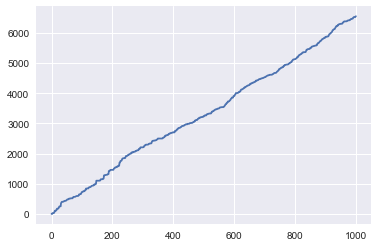

In [33]:
plt.plot(total_fare_received_over_time)
plt.plot(naive_fare_over_time)

In [277]:
list_of_geohashes_visited

['Zc4kK',
 'Zc4kI',
 'Zct8d',
 'Zct8f',
 'Zct81',
 'Zct8f',
 'Zct81',
 'Zct83',
 'Zct89',
 'Zct8_',
 'Zct-V',
 'Zct-X',
 'Zct_A',
 'Zct_C',
 'Zct_I',
 'Zct_K',
 'Zct_g',
 'Zct_i',
 'Zct_h',
 'Zct_j',
 'Zct_p',
 'Zct_r',
 'ZcvVB',
 'ZcvVE',
 'ZcvVG',
 'ZcvVM',
 'ZcvVO',
 'ZcvVk',
 'ZcvVm',
 'ZcvVs',
 'ZcvVu',
 'ZcvXE',
 'Zct9C',
 'Zct9D',
 'Zct9G',
 'Zct9H',
 'Zct9S',
 'Zct9T',
 'Zct9W',
 'Zct9X',
 'Zc4oC',
 'Zc4oD',
 'Zc4oG',
 'Zc4oH',
 'Zc4oS',
 'Zc4oT',
 'Zc4oW',
 'Zc4oX',
 'Zc4pC',
 'Zc4pD',
 'Zc4pG',
 'Zc4pH',
 'Zc4pS',
 'Zc4pT',
 'Zc4pW',
 'Zc4pX',
 'Zc4sC',
 'Zc4sD',
 'Zc4sG',
 'Zc4sJ',
 'Zc4sM',
 'Zc4sN',
 'Zc4sH',
 'Zc4sS',
 'Zct9C',
 'Zct9J',
 'Zct9M',
 'Zct9N',
 'Zct9Y',
 'Zct9Z',
 'Zct9c',
 'Zct9d',
 'Zc4oI',
 'Zc4oC',
 'Zc4oD',
 'Zc4oA',
 'Zc4oB',
 'Zc4oE',
 'Zc4oF',
 'Zc4oQ',
 'Zc4oT',
 'Zc4oW',
 'ZcvXN',
 'ZcvXY',
 'Zct9C',
 'Zct9D',
 'Zct9G',
 'Zct9H',
 'Zct9S',
 'Zct9T',
 'Zct9W',
 'Zct9R',
 'Zct9U',
 'Zct9V',
 'Zc4oA',
 'Zc4oB',
 'Zc4oE',
 'Zc4oF',
 'Zc4oQ',
 'Zc4oR',


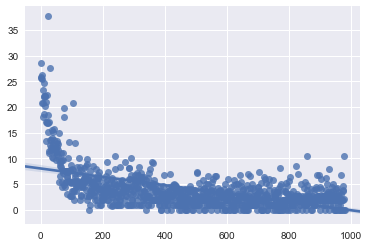

In [278]:
sns.regplot(np.array([_ for _ in range(len(loss_list))]),np.array(loss_list)) 

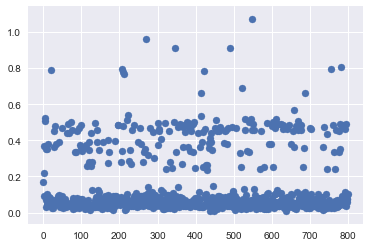

In [91]:
plt.scatter([_ for _ in range(len(loss))],loss)

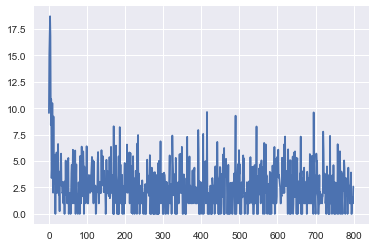

In [96]:
plt.plot(loss) # 1k iterations

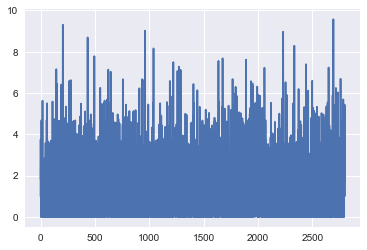

In [99]:
plt.plot(loss)

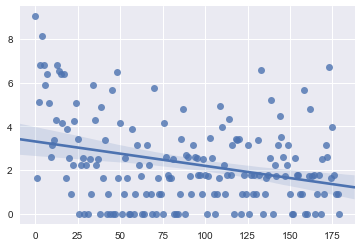

In [232]:
sns.regplot(np.array([_ for _ in range(len(loss))]),np.array(loss)) # 500

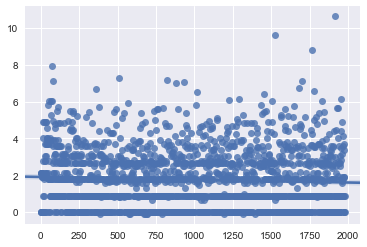

In [155]:
sns.regplot(np.array([_ for _ in range(len(loss))]),np.array(loss)) # 2k 

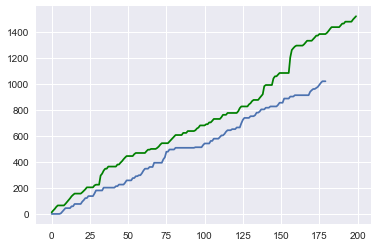

In [212]:
plt.plot(fare_rl )
plt.plot(fare_naive,color='green')

In [385]:
model_simple.predict(np.array([[1950,2138]]))

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

In [386]:
def trainNetwork(model,args):
    # open up a game state to communicate with emulator 
    game_state = game.GameState()

    # store the previous observations in replay memory
    D = deque()

    # get the first state by doing nothing and preprocess the image to 80x80x4
    do_nothing = np.zeros(ACTIONS)
    do_nothing[0] = 1
    x_t, r_0, terminal = game_state.frame_step(do_nothing)

    x_t = skimage.color.rgb2gray(x_t)
    x_t = skimage.transform.resize(x_t,(80,80))
    x_t = skimage.exposure.rescale_intensity(x_t,out_range=(0,255))

    s_t = np.stack((x_t, x_t, x_t, x_t), axis=2)
    #print (s_t.shape)

    #In Keras, need to reshape
    s_t = s_t.reshape(1, s_t.shape[0], s_t.shape[1], s_t.shape[2])  #1*80*80*4
    
    if args['mode'] == 'Run': ## don't need this
        OBSERVE = 999999999    #We keep observe, never train
        epsilon = FINAL_EPSILON
        print ("Now we load weight")
        model.load_weights("model.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)
        print ("Weight load successfully")    
    else:                       #We go to training mode
        OBSERVE = OBSERVATION
        epsilon = INITIAL_EPSILON

    t = 0
    while (True):
        loss = 0
        Q_sa = 0
        action_index = 0
        r_t = 0
        a_t = np.zeros([ACTIONS])
        #choose an action epsilon greedy
        if t % FRAME_PER_ACTION == 0:
            if random.random() <= epsilon:
                print("----------Random Action----------")
                action_index = random.randrange(ACTIONS)
                a_t[action_index] = 1
            else:
                q = model.predict(s_t)       #input a stack of 4 images, get the prediction
                max_Q = np.argmax(q)
                action_index = max_Q
                a_t[max_Q] = 1

        #We reduced the epsilon gradually to take more random actions 
        if epsilon > FINAL_EPSILON and t > OBSERVE:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

        #run the selected action and observed next state and reward
        x_t1_colored, r_t, terminal = game_state.frame_step(a_t)
        

        x_t1 = skimage.color.rgb2gray(x_t1_colored)
        x_t1 = skimage.transform.resize(x_t1,(80,80))
        x_t1 = skimage.exposure.rescale_intensity(x_t1, out_range=(0, 255))

        x_t1 = x_t1.reshape(1, x_t1.shape[0], x_t1.shape[1], 1) #1x80x80x1
        s_t1 = np.append(x_t1, s_t[:, :, :, :3], axis=3)

        # store the transition in D
        D.append((s_t, action_index, r_t, s_t1, terminal))
        if len(D) > REPLAY_MEMORY:
            D.popleft()

        #only train if done observing
        if t > OBSERVE:
            #sample a minibatch to train on
            minibatch = random.sample(D, BATCH) # batch = 16



            inputs = np.zeros((BATCH, s_t.shape[1], s_t.shape[2], s_t.shape[3]))   #32, 80, 80, 4
            print (inputs.shape)
            targets = np.zeros((inputs.shape[0], ACTIONS))                         #32, 2

            #Now we do the experience replay
            for i in range(0, len(minibatch)): # looping through the rows
                state_t = minibatch[i][0]
                action_t = minibatch[i][1]   #This is action index
                reward_t = minibatch[i][2]
                state_t1 = minibatch[i][3]
                terminal = minibatch[i][4]
                # if terminated, only equals reward

                inputs[i:i + 1] = state_t    #I saved down s_t

                targets[i] = model.predict(state_t)  # Hitting each buttom probability, update entire row
                Q_sa = model.predict(state_t1)

                if terminal:
                    targets[i, action_t] = reward_t
                else:
                    targets[i, action_t] = reward_t + GAMMA * np.max(Q_sa)

            # targets2 = normalize(targets)
            loss += model.train_on_batch(inputs, targets)

        s_t = s_t1
        t = t + 1

        # save progress every 10000 iterations
        if t % 1000 == 0:
            print("Now we save model")
            model.save_weights("model.h5", overwrite=True)
            with open("model.json", "w") as outfile:
                json.dump(model.to_json(), outfile)

        # print info
        state = ""
        if t <= OBSERVE:
            state = "observe"
        elif t > OBSERVE and t <= OBSERVE + EXPLORE:
            state = "explore"
        else:
            state = "train"

        print("TIMESTEP", t, "/ STATE", state, \
            "/ EPSILON", epsilon, "/ ACTION", action_index, "/ REWARD", r_t, \
            "/ Q_MAX " , np.max(Q_sa), "/ Loss ", loss)

    print("Episode finished!")
    print("************************")

In [139]:
inputs = np.zeros((BATCH, 80,80,4))

In [141]:
inputs[0:1]

array([[[[ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.]],

        ..., 
        [[ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
    

In [148]:
t = np.arange(10,10000)

In [162]:
t = np.array([[1,2,3,4,5],
             [5,6,4,3,1]])

In [163]:
t

array([[1, 2, 3, 4, 5],
       [5, 6, 4, 3, 1]])

In [164]:
t[0:1] = 1

In [165]:
t

array([[1, 1, 1, 1, 1],
       [5, 6, 4, 3, 1]])

In [166]:
t[1:2] = 2

In [167]:
t

array([[1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2]])